### Quick Start Tutorial for Irregular Resampling Auto Spectral Analysis (IRASA)

This tutorial provides a brief example for using CML's IRASA package for separating oscillatory signals from the 1/f pink noise background. The method is adapted from the 2016 paper by Haiguang Wen and Zhongming Liu, *Separating Fractal and Oscillatory Components in the Power Spectrum of Neurophysiological Signal*

Citation: Brain Topogr. 2016 January ; 29(1): 13–26. doi:10.1007/s10548-015-0448-0.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmlreaders as cml
from irasa.IRASA import IRASA

Pick a subject, and load up their corresponding events, electrode configuraions (we'll use bipolar pairs), and eeg. 

In [2]:
subject = 'R1195E'
reader = cml.CMLReader(subject = subject, experiment = 'FR1', session = 0)
pairs = reader.load("pairs")
events = reader.load('task_events')
word_events = events[events.type=='WORD']  # select encoding events 
eeg = reader.load_eeg(events = word_events, scheme = pairs, rel_start=300, rel_stop=1300).to_ptsa().mean('channel')

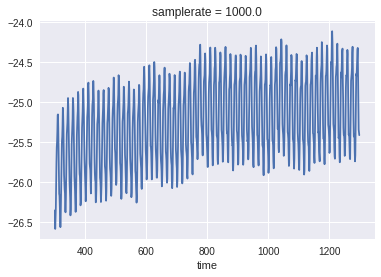

In [3]:
eeg.mean('event').plot()

#### IRASA Class

Initialization parameters:  
**sig** - timeseries data (last axis (axis = -1) must be time/samples)  
**freqs** - 1D array of desired frequencies. This does not actually affect computation, it just determines the range of frequencies which are returned at the end  
**samplerate** - sample rate in Hz  
**hset** - array of resampling factors (>1)  
**flag_filter**  - 1 or 0 (default 1): 1 means filtering before downsampling to avoid aliasing.  
**flag_detrend** - 1 or 0 (default 1): 1 means detrending data before fft

**VERY IMPORTANT: note that the method assumes that time is the last axis, and will not work properly if this assumption is not satisfied!**

Initialize and IRASA object by entering the EEG and a frequency range for the desired spectrum

In [4]:
irasa = IRASA(eeg, freqs=np.arange(2, 30))

Removing linear trend
Filtering to avoid aliasing
Computing fractal PSD
Time elapsed for FFT: 6.9896 s


Use the built-in plotting methods to visualize the power spectrum and compare the original mixed signal to the separated fractal component. This fractal component should be linear in log-log coordinates.

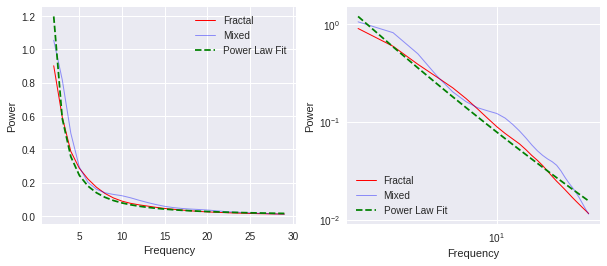

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(121)
irasa.psdplot(fit=True)
plt.subplot(122)
irasa.loglogplot(fit=True)

Plot the oscillatory signal, which is equal to the difference of the mixed and fractal signals.

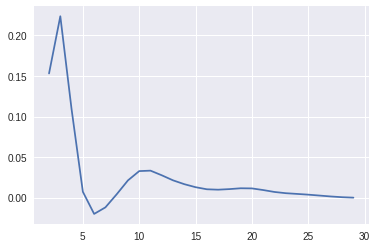

In [6]:
irasa.plot_oscillatory()

To work with the data more directly and create custom analyses, access the IRASA object's attributes.  
Important Attributes:  
**.freqs** - frequency values at which power was evaluated  
**.mixed** - PSD of the mixed signal contianing both fractal and oscillatory components  
**.fractal** - separated fractal component of the PSD

The PSD of the oscillatory component can be obtained indirectly, by subtracting .fractal from .mixed. Here we'll log transform the spectra in order to normalize the data a bit (*before* taking the difference, since we can't log negative numbers)

In [7]:
osc = np.log10(irasa.mixed) - np.log10(irasa.fractal)

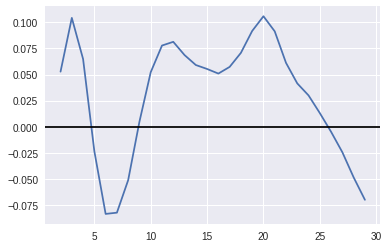

In [8]:
plt.plot(irasa.freqs, osc.mean(0))
plt.axhline(0, c='k')

For example, we can use boolean indexing to separate IRASA by recall performance

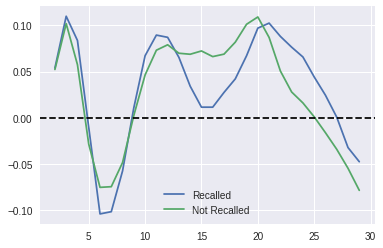

In [9]:
rec_mask = word_events.recalled.astype(bool).values
plt.plot(irasa.freqs, osc[rec_mask].mean(0), label='Recalled')
plt.plot(irasa.freqs, osc[~rec_mask].mean(0), label='Not Recalled')
plt.axhline(0, c='k', linestyle='--')
plt.legend()

Now, let's compare this to a more traditional PSD. Let's compute a morlet wavelet decomposition and compare the recalled and not recalled powers:

CPP total time wavelet loop:  0.6359710693359375


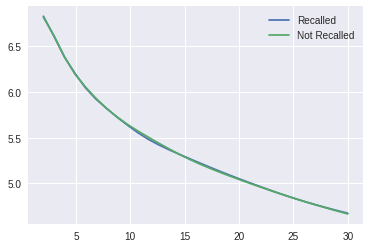

In [10]:
from ptsa.data.filters import MorletWaveletFilter
eeg.add_mirror_buffer(.5)
pows, _ = MorletWaveletFilter(eeg, np.linspace(2, 30, 30)).filter()
pows.remove_buffer(.5)
pows = np.log10(pows.mean('time').values)
plt.plot(np.linspace(2, 30, 30), pows[:, rec_mask].mean(1), label='Recalled')
plt.plot(np.linspace(2, 30, 30), pows[:, ~rec_mask].mean(1), label='Not Recalled')
plt.legend()

This is way less informative than IRASA! We're not interested in the pink noise background as much as we are interested in the oscillations that deviate from it. IRASA helps us analyze these oscillations by separating them from the "fractal" pink noise component.

#### Fitting the fractal component

The plotting method above fit the fractal component to a 1/f function. You can also do this directly, and access the fit parameters and values. This can be useful if you want to evaluate the nature of the background spectrum or how it changes between conditions (i.e. spectral tilt).

In [11]:
p, plaw = irasa.plaw_fit()

Fit parameters in descending order, along the first axis. Subsequent axes are events (and/or channels)

In [12]:
print("Slopes: ", p[0, :10])
print("Intercepts: ", p[1, :10])

Slopes:  [-1.56571086 -1.69061192 -1.40874368 -1.51958901 -0.65678147 -1.3602723
 -1.79479088 -1.26169741 -1.78592276 -1.83320139]
Intercepts:  [-0.07812894  0.74262632  0.26672182  0.17590382 -0.62820481  0.19291203
  0.67877095 -0.11654246  0.72377468  0.67080585]


The spectrum itself

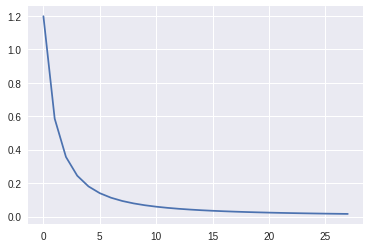

In [13]:
plt.plot(plaw.mean(0))

The fit parameters and fitted spectrum can also be accessed with the .fit_params and .fit attributes, respectively.